# Evaluate Geolocation Predictions of Osv5M Model
This notebook evaluates the geolocation predictions of the Osv5M model trained on the CrossLocate (Uniform) dataset using geodesic distance and plots a recall curve.

In [213]:
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import matplotlib.ticker as ticker
import os
from math import radians, sin, cos, sqrt, atan2
from utils import print_recall_at_thresholds, compute_distances, plot_recall_curve, eval_error_distribution, plot_loss, evaluate_geolocation

In [ ]:
gt_df = pd.read_csv("../../data/gt/datasetInfoClean.csv")
pred_before = pd.read_csv("../../data/results/baseline/geolocations_uniform.csv")
pred_new_frozen = pd.read_csv("../../data/results/new_head_freeze/finetuned_predictions9.csv")
pred_new_full = pd.read_csv("../../data/results/new_head_full/finetuned_predictions9.csv")
pred_original_frozen = pd.read_csv("../../data/results/original_head_frozen/finetuned_predictions9.csv")
pred_original_full= pd.read_csv("../../data/results/original_head_full/finetuned_predictions9.csv")
pred_admin_full = pd.read_csv("../../data/results/admin_full/finetuned_predictions4.csv")
pred_caa_full = pd.read_csv("../../data/results/caa_full/finetuned_predictions4.csv")
pred_bc_freeze = pd.read_csv("../../data/results/basic_clip/finetuned_predictions10.csv")
pred_geoclip_freeze = pd.read_csv("../../data/results/geoclip/finetuned_predictions7.csv")
pred_bc_unfreeze = pd.read_csv("../../data/results/basic_clip/finetuned_predictions7.csv")
pred_new_head_freeze_h = pd.read_csv("../../data/results/haversine_freeze/finetuned_predictions3.csv")

In [215]:
thresholds=[1000, 25000, 200000, 450000, 750000]

## Evaluation (Recall/distance)

In [216]:
pred_before["image"] = pred_before["image"].apply(lambda x: os.path.splitext(x)[0])

# new head
pred_new_frozen["image"] = pred_new_frozen["image"].apply(lambda x: os.path.splitext(x)[0])
pred_new_full["image"] = pred_new_full["image"].apply(lambda x: os.path.splitext(x)[0])
pred_new_head_freeze_h["image"] = pred_new_head_freeze_h["image"].apply(lambda x: os.path.splitext(x)[0])

# original head
pred_original_frozen["image"] = pred_new_head_freeze_h["image"].apply(lambda x: os.path.splitext(x)[0])
pred_original_full["image"] = pred_original_full["image"].apply(lambda x: os.path.splitext(x)[0])

# hybrid
pred_admin_full["image"] = pred_admin_full["image"].apply(lambda x: os.path.splitext(x)[0])
pred_caa_full["image"] = pred_caa_full["image"].apply(lambda x: os.path.splitext(x)[0])

# basic clip
pred_bc_freeze["image"] = pred_bc_freeze["image"].apply(lambda x: os.path.splitext(x)[0])
pred_bc_unfreeze["image"] = pred_bc_unfreeze["image"].apply(lambda x: os.path.splitext(x)[0])

# geoclip
pred_geoclip_freeze["image"] = pred_geoclip_freeze["image"].apply(lambda x: os.path.splitext(x)[0])

# Match with GT
gt_df["image"] = gt_df["image"].astype(str).str.strip()

# Restrict GT and pred_before to images that exist in pred_after
valid_images = set(pred_new_full["image"])
gt_df = gt_df[gt_df["image"].isin(valid_images)].copy()
pred_before = pred_before[pred_before["image"].isin(valid_images)].copy()
pred_bc_freeze = pred_bc_freeze[pred_bc_freeze["image"].isin(valid_images)].copy()
pred_bc_unfreeze = pred_bc_unfreeze[pred_bc_unfreeze["image"].isin(valid_images)].copy()
pred_geoclip_freeze = pred_geoclip_freeze[pred_geoclip_freeze["image"].isin(valid_images)].copy()

In [217]:
dist_before = compute_distances(gt_df, pred_before)
dist_new_full = compute_distances(gt_df, pred_new_full)
dist_new_frozen = compute_distances(gt_df, pred_new_frozen)
dist_original_full = compute_distances(gt_df, pred_original_full)
dist_original_frozen = compute_distances(gt_df, pred_original_frozen)
dist_admin_full = compute_distances(gt_df, pred_admin_full)
dist_caa_full = compute_distances(gt_df, pred_caa_full)
dist_bc_freeze = compute_distances(gt_df, pred_bc_freeze)
dist_bc_unfreeze = compute_distances(gt_df, pred_bc_unfreeze)
dist_geoclip_freeze = compute_distances(gt_df, pred_geoclip_freeze)
dist_nh_freeze = compute_distances(gt_df, pred_new_head_freeze_h)

In [218]:
print_recall_at_thresholds(dist_before, "Before", thresholds)


Recall for Before:
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.047
  Recall @ 200 km: 0.793
  Recall @ 450 km: 0.940
  Recall @ 750 km: 0.944


In [257]:
evaluate_geolocation(gt_df, pred_bc_freeze)

modality_image                                  6979
image                alps_eig_29003907366_af2508a055
latitude                                     46.5473
longitude                                    7.98518
height                                       3579.45
alfa                                       -0.231153
beta                                       -0.218828
gamma                                       0.004702
fov                                         0.844519
image_pred           alps_eig_29003907366_af2508a055
longitude_radians                           0.139752
latitude_radians                            0.811947
image_clean          alps_eig_29003907366_af2508a055
pred_lat_deg                               46.521146
pred_lon_deg                                  8.0072
Name: 2176, dtype: object
modality_image                                     1522
image                flickr_sge_3870703827_d6208aeff7_o
latitude                                        46.7967
longitude  

### (Osv5M) Finetuned regression with new pure regression head

In [220]:
print_recall_at_thresholds(dist_new_frozen, "New (frozen)", thresholds)
print_recall_at_thresholds(dist_new_full, "New (full)", thresholds)


Recall for New (frozen):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.009
  Recall @ 200 km: 0.509
  Recall @ 450 km: 0.933
  Recall @ 750 km: 0.993

Recall for New (full):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.078
  Recall @ 200 km: 0.841
  Recall @ 450 km: 0.999
  Recall @ 750 km: 1.000


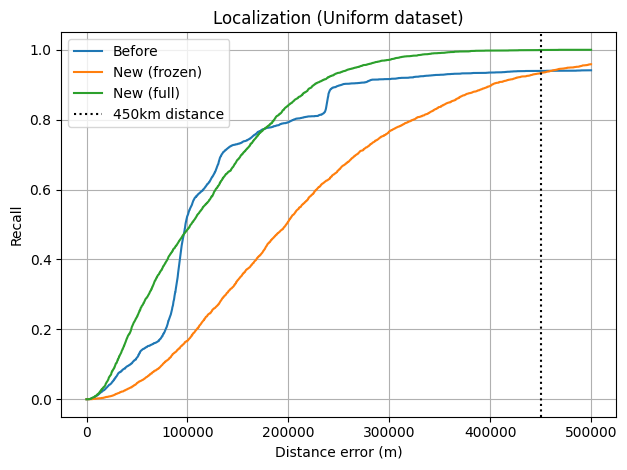

In [221]:
plot_recall_curve([dist_before, 
                    dist_new_frozen, 
                    dist_new_full, 
                       ], 
                       ["Before", 
                        "New (frozen)", 
                        "New (full)",
                        ], max_dist=500_000, axvline = 450_000) 

### (Osv5M) Finetuned regreesion with original hybrid head

In [222]:
print_recall_at_thresholds(dist_original_frozen, "Original (frozen)", thresholds)
print_recall_at_thresholds(dist_original_full, "Original (full)", thresholds)


Recall for Original (frozen):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.044
  Recall @ 200 km: 0.790
  Recall @ 450 km: 0.939
  Recall @ 750 km: 0.942

Recall for Original (full):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.011
  Recall @ 200 km: 0.227
  Recall @ 450 km: 0.424
  Recall @ 750 km: 0.445


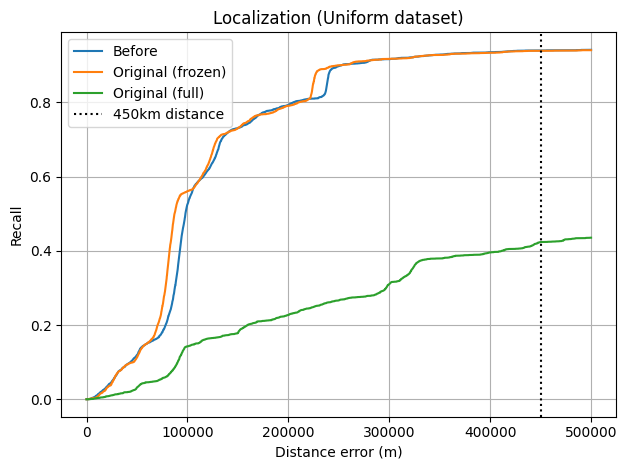

In [223]:
plot_recall_curve([dist_before, 
                     dist_original_frozen, 
                     dist_original_full
                       ], 
                       ["Before", 
                        "Original (frozen)", 
                        "Original (full)"
                        ], max_dist=500_000, axvline = 450_000) 

### (Osv5M) Supervisied finetuning regression with OSM classes

In [224]:
print_recall_at_thresholds(dist_admin_full, "Admin (full)", thresholds)
print_recall_at_thresholds(dist_caa_full, "Country+admin1+admin2 (full)", thresholds)


Recall for Admin (full):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.000
  Recall @ 200 km: 0.000
  Recall @ 450 km: 0.002
  Recall @ 750 km: 0.002

Recall for Country+admin1+admin2 (full):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.000
  Recall @ 200 km: 0.000
  Recall @ 450 km: 0.001
  Recall @ 750 km: 0.585


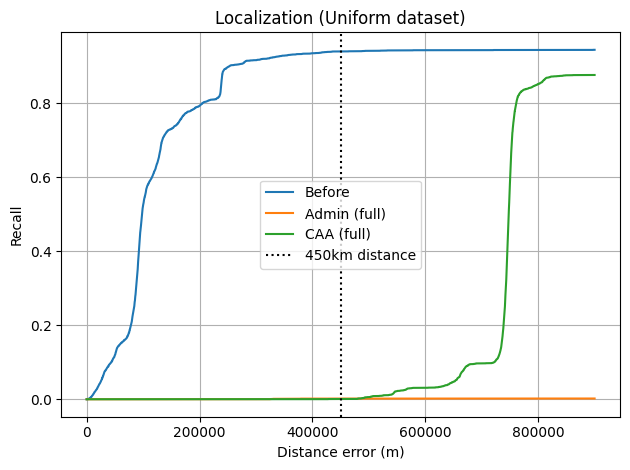

In [225]:
plot_recall_curve([dist_before, 
                       dist_admin_full,
                       dist_caa_full
                       ], 
                       ["Before", 
                        "Admin (full)",
                        "CAA (full)"
                        ], max_dist=900_000, axvline = 450_000) 

### (Simple Clip, GeoClip) Finetunined regression

In [226]:
thresholds_clip=[1000, 25000, 200000, 350000, 450000]

print_recall_at_thresholds(dist_bc_freeze, "Basic Clip (freeze)", thresholds_clip)
print_recall_at_thresholds(dist_geoclip_freeze, "GeoClip (freeze)", thresholds_clip)
print_recall_at_thresholds(dist_nh_freeze, "New (harvesine, freeze)", thresholds_clip)



Recall for Basic Clip (freeze):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.026
  Recall @ 200 km: 0.906
  Recall @ 350 km: 0.994
  Recall @ 450 km: 0.999

Recall for GeoClip (freeze):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.010
  Recall @ 200 km: 0.812
  Recall @ 350 km: 0.987
  Recall @ 450 km: 0.999

Recall for New (harvesine, freeze):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.008
  Recall @ 200 km: 0.718
  Recall @ 350 km: 0.989
  Recall @ 450 km: 1.000


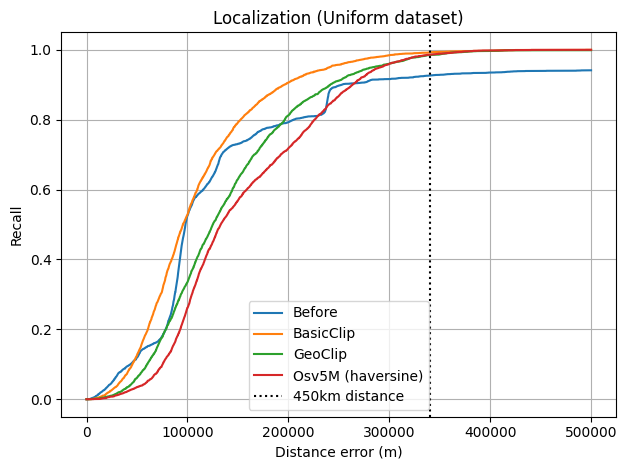

In [227]:
plot_recall_curve([dist_before, 
                       dist_bc_freeze,
                       dist_geoclip_freeze,
                       dist_nh_freeze
                       ], 
                       ["Before", 
                        "BasicClip",
                        "GeoClip",
                        "Osv5M (haversine)"
                        ], max_dist=500_000, axvline = 340_000) 

### All models evaluation

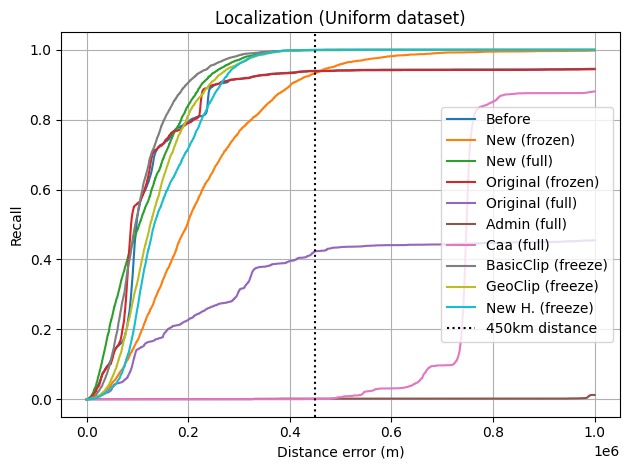

In [228]:
plot_recall_curve([dist_before, 
                       dist_new_frozen, 
                       dist_new_full, 
                       dist_original_frozen, 
                       dist_original_full,
                       dist_admin_full,
                       dist_caa_full,
                       dist_bc_freeze,
                       dist_geoclip_freeze,
                       dist_nh_freeze
                       ], 
                       ["Before", 
                        "New (frozen)", 
                        "New (full)", 
                        "Original (frozen)", 
                        "Original (full)",
                        "Admin (full)",
                        "Caa (full)",
                        "BasicClip (freeze)",
                        "GeoClip (freeze)",
                        "New H. (freeze)"
                        ], max_dist=1000000, axvline = 450_000) 

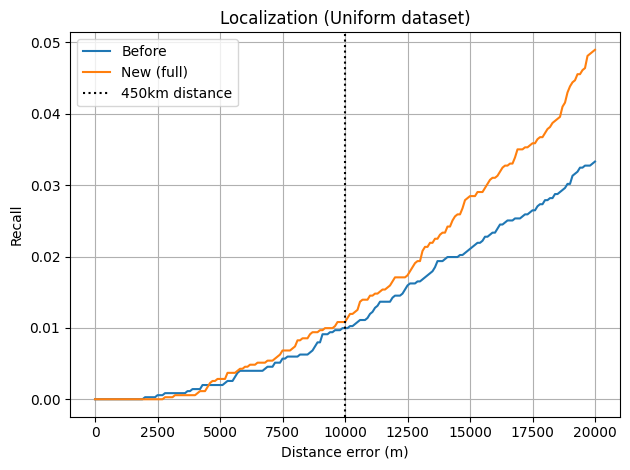

In [229]:
plot_recall_curve([dist_before, dist_new_full], ["Before", "New (full)"], max_dist=20_000, step=100, axvline=10_000)

## Error distribution

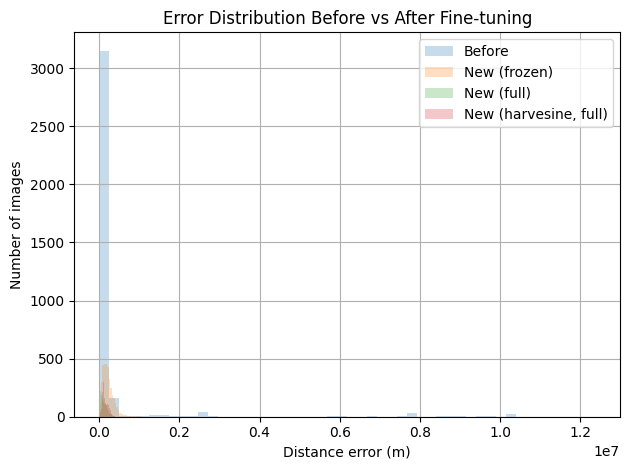

In [230]:
eval_error_distribution([dist_before, 
                       dist_new_frozen, 
                       dist_new_full,
                       dist_nh_freeze], ["Before", 
                        "New (frozen)", 
                        "New (full)", 
                        "New (harvesine, full)"])

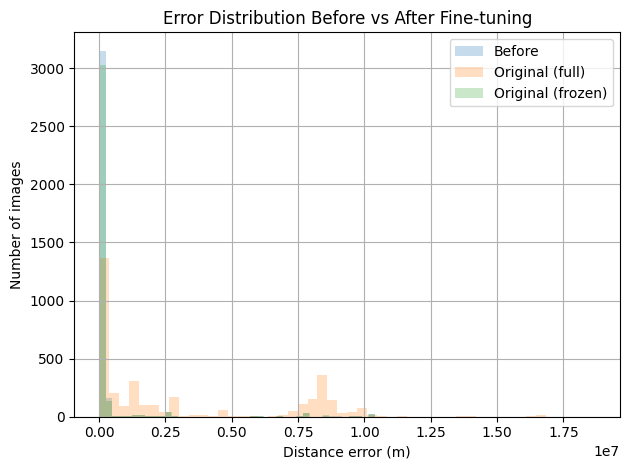

In [231]:
eval_error_distribution([dist_before, 
                       dist_original_full, 
                       dist_original_frozen], ["Before", 
                        "Original (full)", 
                        "Original (frozen)"
                        ])

## Loss evaluation (train, validation)

### Simple regression

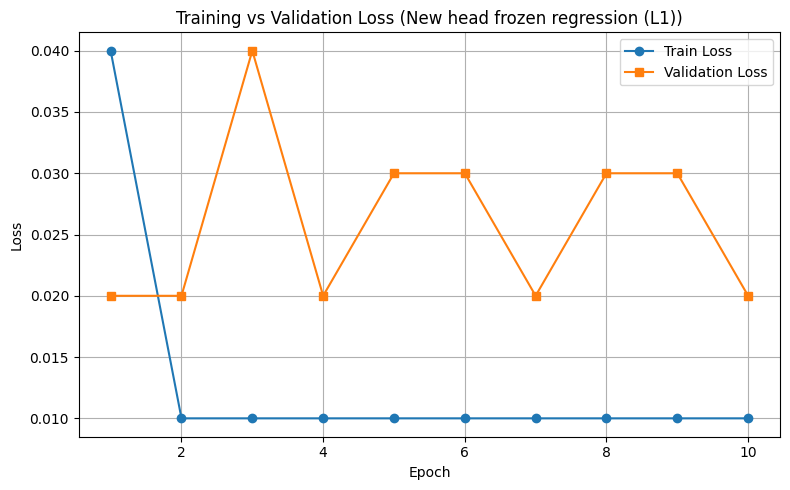

In [232]:
train_loss = [0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
val_loss = [0.02, 0.02, 0.04, 0.02, 0.03, 0.03, 0.02, 0.03, 0.03, 0.02]
plot_loss(train_loss, val_loss, "New head frozen regression (L1)")

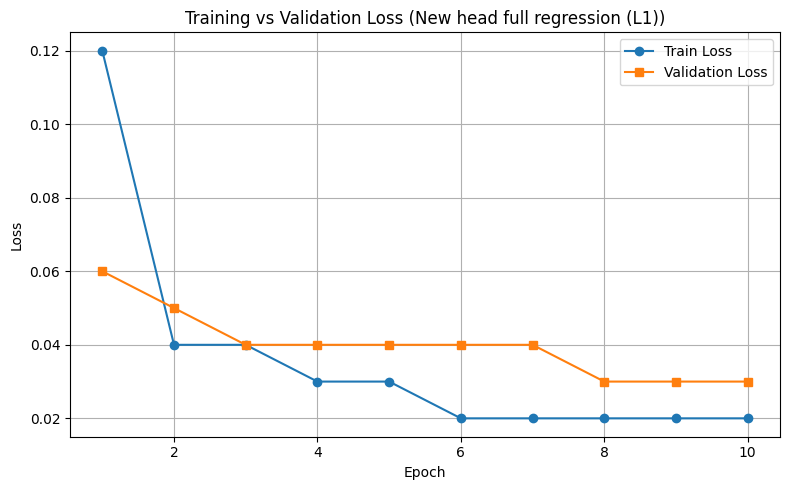

In [233]:
train_loss = [0.12, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02]
val_loss = [0.06, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03]
plot_loss(train_loss, val_loss, "New head full regression (L1)")

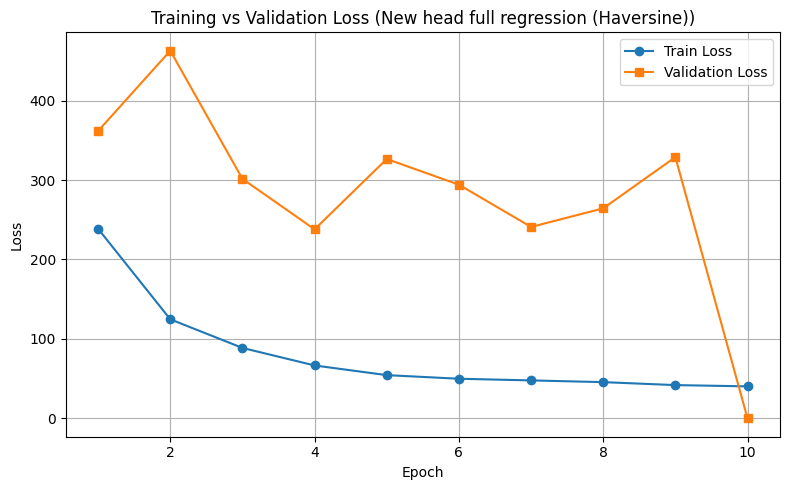

In [234]:
train_loss_harv = [238.59, 124.70, 88.67, 66.60, 54.43, 49.89, 47.79, 45.62, 41.89, 40.30]
val_loss_harv = [361.75, 462.74, 301.45, 237.95, 326.44, 294.12, 240.93, 264.33, 328.83, 0.05]
plot_loss(train_loss_harv, val_loss_harv, "New head full regression (Haversine)")

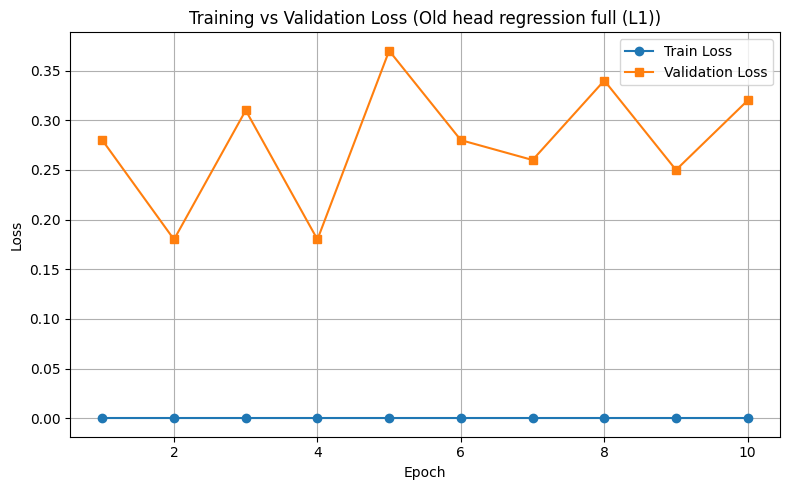

In [235]:
train_loss = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
val_loss = [0.28, 0.18, 0.31, 0.18, 0.37, 0.28, 0.26, 0.34, 0.25, 0.32]
plot_loss(train_loss, val_loss, "Old head regression full (L1)")

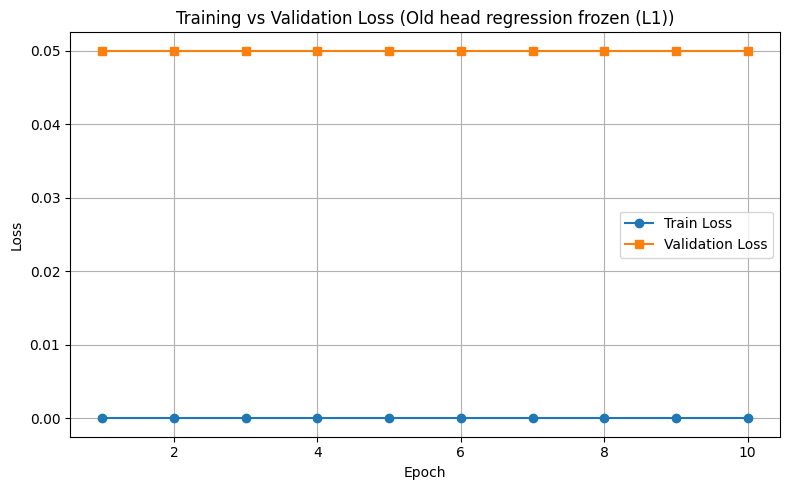

In [236]:
train_loss = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
val_loss = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
plot_loss(train_loss, val_loss, "Old head regression frozen (L1)")

### Supervised regression

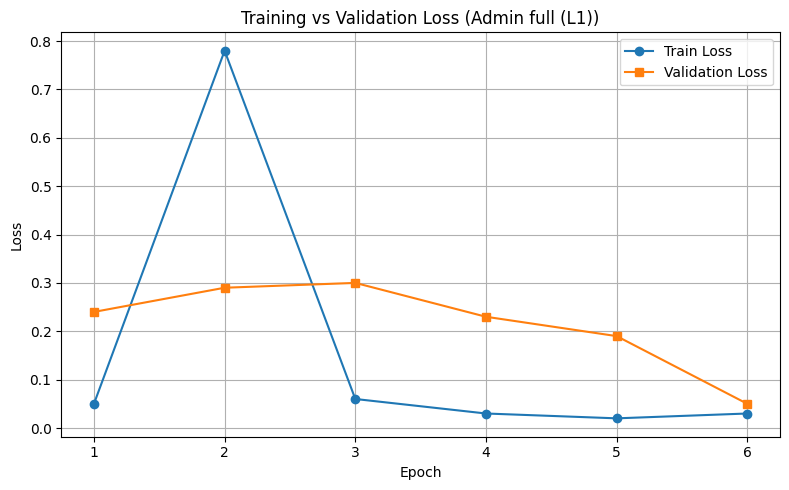

In [237]:
train_loss = [0.05, 0.78, 0.06, 0.03, 0.02, 0.03]
val_loss = [0.24, 0.29, 0.3, 0.23, 0.19, 0.05]
plot_loss(train_loss, val_loss, "Admin full (L1)")

#train_loss_harv = [1468.73, 3863.78, 1765.14, 1187.96, 1007.2]
#val_loss_harv = [3724.25, 3907.14, 3515.39, 3552.42, 3202.01]

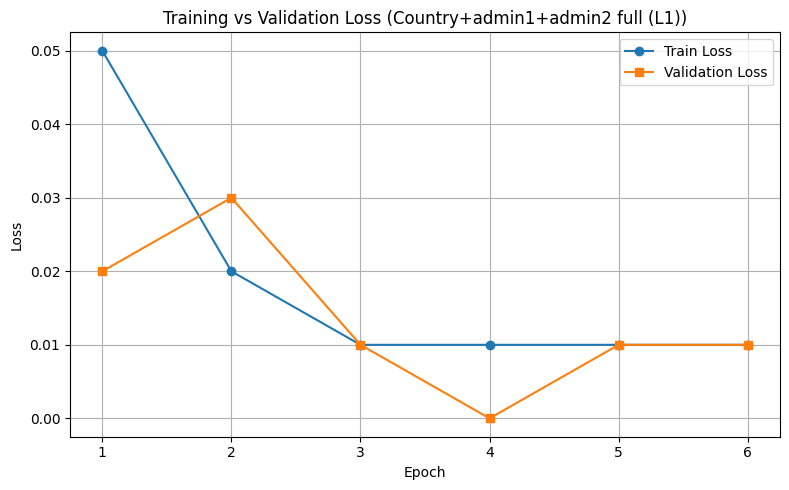

In [238]:
train_loss = [0.05, 0.02, 0.01, 0.01, 0.01, 0.01]
val_loss = [0.02, 0.03, 0.01, 0.00, 0.01, 0.01]
plot_loss(train_loss, val_loss, "Country+admin1+admin2 full (L1)")

#train_loss_harv = [1491.25, 1053.23, 750.67, 666.95, 626.85]
#val_loss_harv = [858.37, 1282.82, 641.77, 335.34, 665.54]

## Clips

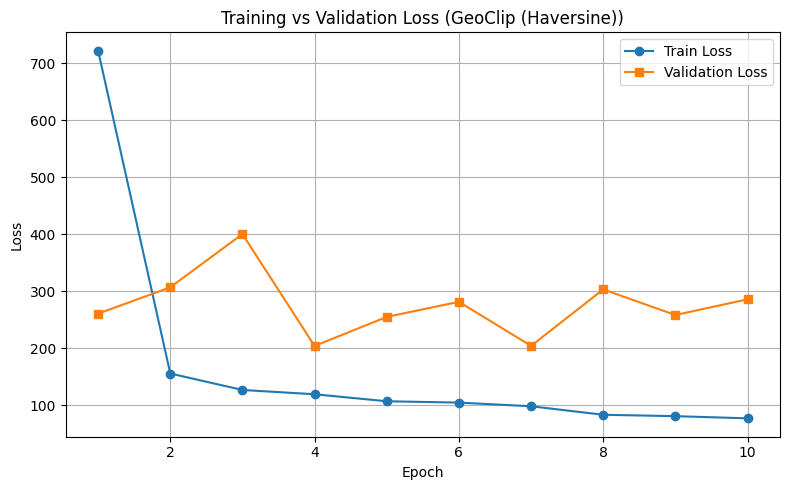

In [239]:
train_loss = [
    721.8900777953339,
    155.29837995214797,
    126.411210257637,
    118.86629143659454,
    106.5829750365331,
    104.23419221715822,
    97.80686816500105,
    82.87508956564555,
    80.4272300723881,
    76.60048835017486
]

val_loss = [
    260.334534164547,
    306.6470859734587,
    400.0788233557413,
    203.66637284626333,
    254.67852783203125,
    281.1187763066255,
    203.80269344832547,
    302.8703615646954,
    257.98775771976443,
    285.4801067973292
]

plot_loss(train_loss, val_loss, "GeoClip (Haversine)")

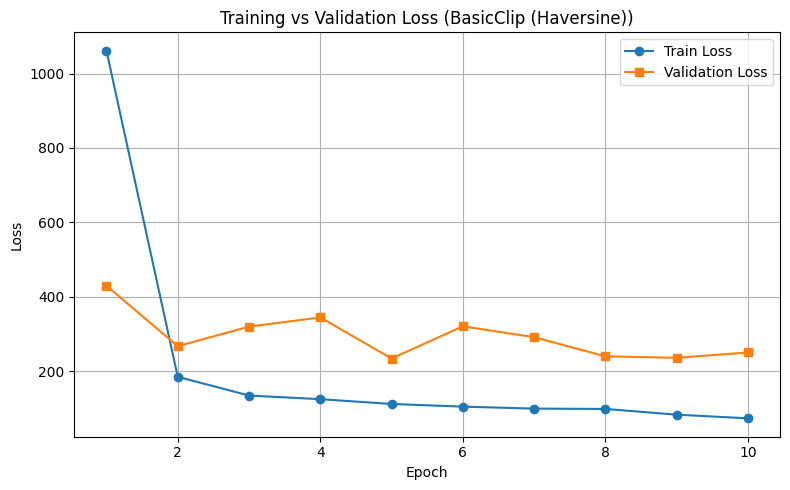

In [240]:
train_loss = [
    1061.7048536279578,
    184.39782464074608,
    134.14039469567243,
    124.27747050940216,
    111.420707911611,
    104.23207507667377,
    98.93920375635165,
    98.02384530781897,
    82.60499695572126,
    72.7473711584807
]

val_loss = [
    429.3743499046148,
    266.86623625052994,
    319.5286217031553,
    344.0651117369186,
    233.71126988137416,
    320.2863305853319,
    290.9931640625,
    239.55593943041424,
    235.54659963208576,
    249.9973821122517
]


plot_loss(train_loss, val_loss, "BasicClip (Haversine)")

## GeoScore

In [241]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [242]:
def compute_geoscore_osv5m(gt_df, pred_df):
    # Join predictions to ground truth by image name
    merged = pd.merge(pred_df, gt_df, on='image', how='inner')

    # Convert GT lat/lon to radians
    lat_gt_rad = np.radians(merged['latitude'])
    lon_gt_rad = np.radians(merged['longitude'])

    # Prediction already in radians
    lat_pred = merged['latitude_radians']
    lon_pred = merged['longitude_radians']

    # Compute distance
    distances = haversine_distance(lat_gt_rad, lon_gt_rad, lat_pred, lon_pred)

    # GeoScore as in OSV5M paper
    return np.mean(5000 * np.exp(-distances / 1492.7))

,image,longitude_radians,latitude_radians
1,28561570606,0.201230,0.808049
159,alps_cham_15032490209_78a8d799f0,0.137320,0.806259
356,alps_cham_21214974325_b7044230c1,0.123994,0.795537
473,alps_cham_2685146654_d70b9eea18,0.116312,0.799767
669,alps_cham_29088319972_a6c87c4827,0.124620,0.803221
...,...,...,...
12347,sp_toedi1,0.140132,0.809853
12348,sp_toedi2,0.171213,0.812153
12349,taschhorn,0.167570,0.809752
12350,taschhorn02,0.159598,0.806769


In [ ]:
pred_before["image"] = pred_before["image_clean"] 

In [250]:
geo_scores_osv5m = {
    "BasicCLIP": compute_geoscore_osv5m(gt_df, pred_bc_freeze),
    "GeoCLIP": compute_geoscore_osv5m(gt_df, pred_geoclip_freeze),
    "OSV5M Haversine": compute_geoscore_osv5m(gt_df, pred_new_head_freeze_h),
    "Before": compute_geoscore_osv5m(gt_df, pred_before)
}

geo_scores_osv5m

{'BasicCLIP': np.float64(4647.058386982962),
 'GeoCLIP': np.float64(4556.937046027263),
 'OSV5M Haversine': np.float64(4512.143883583103),
 'Before': np.float64(4392.86869256553)}